# Notebook 04: Эксперименты по визуализации

### Введение

Этот ноутбук — наша творческая "песочница" для исследования новых способов визуализации нашего многоканального набора данных CMB. Цель — протестировать различные методы построения графиков, чтобы лучше понять структуру данных и, возможно, найти способы наглядно выделить аномалии, которые наша модель найдёт в будущем.

### Шаг 1: Полная настройка среды и загрузка всех данных

Эта первая ячейка является главной точкой входа в ноутбук. Она выполняет все необходимые подготовительные действия:

* **Настройка среды:** Монтирует Google Drive для доступа к нашим файлам и устанавливает специализированные библиотеки (`scikit-image`, `healpy`), необходимые для обработки изображений и космологических карт.
* **Определение путей:** Задаёт константы для путей к папкам проекта, что делает код более чистым и удобным для чтения.
* **Загрузка всех артефактов:** Загружает все четыре ключевых артефакта, созданных в предыдущих ноутбуках:
    1.  **Статистику нормализации (`.json`):** Необходима для правильного масштабирования данных при визуализации.
    2.  **Полномасштабные карты I, Q, U (`.fits`):** Исходные научные данные для создания глобальных визуализаций.
    3.  **Галактическую маску (`.fits`):** Необходима для правильного отображения областей, исключённых из анализа.
    4.  **Датасет патчей (`.tfrecord`):** Основной набор данных для экспериментов с визуализацией отдельных участков неба.

In [2]:
# --- 1. Настройка среды ---
print("Настройка среды...")
# Монтируем Google Drive для доступа к файлам проекта.
from google.colab import drive
drive.mount('/content/drive')

# Устанавливаем необходимые библиотеки, если они ещё не установлены.
# -q (quiet) подавляет лишний вывод.
!pip install scikit-image healpy -q

# Импортируем все необходимые библиотеки.
import os
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import healpy as hp
from skimage import color
print("Библиотеки импортированы.")

# --- 2. Определение путей ---
# Определяем основные пути, чтобы не прописывать их каждый раз вручную.
project_path = '/content/drive/My Drive/CosmicLegacy'
data_path = os.path.join(project_path, 'data')
print(f"Путь к проекту: {project_path}")

# --- 3. Загрузка ВСЕХ необходимых данных ---

# A. Загрузка статистики для нормализации из файла JSON.
print("\nЗагрузка статистики для нормализации...")
stats_filepath = os.path.join(data_path, "normalization_stats_3_channel.json")
try:
    with open(stats_filepath, 'r') as f:
        normalization_stats = json.load(f)
    print(" -> Статистика для нормализации успешно загружена.")
except FileNotFoundError:
    print(f" -> ОШИБКА: Файл со статистикой не найден по пути {stats_filepath}")
    normalization_stats = None

# B. Загрузка полномасштабных карт I, Q, U из файла FITS.
print("\nЗагрузка полномасштабных карт I, Q, U...")
map_filepath = os.path.join(data_path, "planck_cmb_map.fits")
if os.path.exists(map_filepath):
    # hp.read_map может принимать кортеж в аргументе 'field' для загрузки нескольких карт одновременно.
    cmb_map_I, cmb_map_Q, cmb_map_U = hp.read_map(map_filepath, field=(0, 1, 2))
    print(" -> Полномасштабные карты I, Q, U успешно загружены.")
else:
    print(f" -> ОШИБКА: Файл с картами не найден по пути {map_filepath}")
    # Определяем переменные-заглушки, чтобы избежать ошибок в последующих ячейках.
    cmb_map_I, cmb_map_Q, cmb_map_U = (None, None, None)

# C. Загрузка галактической маски.
print("\nЗагрузка галактической маски...")
mask_filepath = os.path.join(data_path, "COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits")
if os.path.exists(mask_filepath):
    galactic_mask = hp.read_map(mask_filepath)
    print(" -> Галактическая маска успешно загружена.")
else:
    print(f" -> ОШИБКА: Файл с маской не найден по пути {mask_filepath}")
    galactic_mask = None

# D. Подготовка конвейера данных для патчей из файла TFRecord.
print("\nПодготовка конвейера данных для патчей...")
# Вспомогательная функция для "расшифровки" (десериализации) записей из файла.
def _parse_function(example_proto):
    feature_description = {
        'patch': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    patch_tensor = tf.io.parse_tensor(example['patch'], out_type=tf.float32)
    patch_tensor = tf.reshape(patch_tensor, [32, 32, 3]) # Убеждаемся, что форма правильная.
    return patch_tensor

final_filename = "cmb_patches_dataset_final.tfrecord"
final_filepath = os.path.join(data_path, final_filename)
if os.path.exists(final_filepath):
    # Создаём "потоковый" объект Dataset, который читает данные с диска по мере необходимости.
    raw_dataset = tf.data.TFRecordDataset(final_filepath)
    # Создаём финальный конвейер, который "на лету" преобразует данные в изображения.
    dataset = raw_dataset.map(_parse_function)
    print(f" -> Датасет с патчами готов к использованию из файла: {final_filepath}")
else:
    print(f" -> ОШИБКА: Файл с датасетом не найден по пути {final_filepath}")
    dataset = None

print("\n--- Настройка и загрузка данных завершены ---")


Настройка среды...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 61.3 MB/s eta 0:00:00
Библиотеки импортированы.
Путь к проекту: /content/drive/My Drive/CosmicLegacy

Загрузка статистики для нормализации...
 -> Статистика для нормализации успешно загружена.

Загрузка полномасштабных карт I, Q, U...
 -> Полномасштабные карты I, Q, U успешно загружены.

Загрузка галактической маски...
 -> Галактическая маска успешно загружена.

Подготовка конвейера данных для патчей...
 -> Датасет с патчами готов к использованию из файла: /content/drive/My Drive/CosmicLegacy/data/cmb_patches_dataset_final.tfrecord

--- Настройка и загрузка данных завершены ---


### Шаг 2: Визуализация отдельного патча в цветовой модели LAB

Теперь, когда все данные загружены, мы можем приступить к нашему первому эксперименту. Цель этой ячейки — проверить нашу основную идею: можем ли мы создать осмысленное цветное изображение одного участка неба, используя цветовую модель LAB.

Процесс состоит из следующих шагов:
1.  **Выборка:** Мы берём один случайный патч из нашего большого набора данных `.tfrecord`. Использование `.shuffle()` гарантирует, что при каждом запуске мы будем видеть новый, случайный участок неба.
2.  **Масштабирование:** Данные в нашем патче нормализованы в диапазоне [0, 1] для каждого канала. Мы масштабируем их в целевые диапазоны, требуемые для цветового пространства LAB:
    * **Канал L (Яркость):** Сопоставляется с Температурой (I). Целевой диапазон: [0, 100].
    * **Канал 'a' (Зелёный-Красный):** Сопоставляется с Поляризацией (Q). Целевой диапазон: [-128, 127].
    * **Канал 'b' (Синий-Жёлтый):** Сопоставляется с Поляризацией (U). Целевой диапазон: [-128, 127].
3.  **Сборка и конвертация:** Мы объединяем эти три масштабированных канала в одно LAB-изображение и затем используем `scikit-image` для его преобразования в стандартный формат RGB, который может быть отображён на экране.
4.  **Визуализация:** Мы отображаем финальное цветное изображение рядом с его тремя исходными каналами (в градациях серого) для наглядного сравнения.


Визуализация данных CMB в цветовом пространстве LAB...


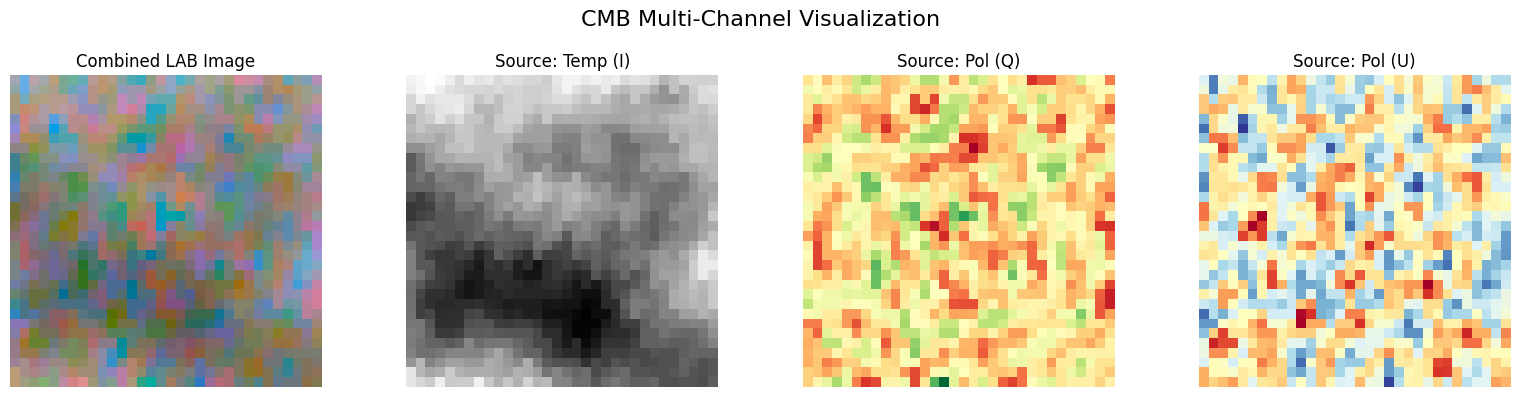

In [36]:
# Импортируем 'color' из scikit-image для преобразования цветовых пространств.
from skimage import color

if 'dataset' in locals() and dataset is not None:
    # --- 1. Берём один случайный патч из нашего набора данных ---
    # Мы перемешиваем датасет с буфером в 100 элементов, чтобы получить новый случайный образец при каждом запуске.
    shuffled_dataset = dataset.shuffle(buffer_size=100)
    # .take(1) берёт один элемент, а next(iter(...)) извлекает его.
    sample_patch_normalized = next(iter(shuffled_dataset))

    # --- 2. Масштабируем каждый канал в целевой диапазон цветового пространства LAB ---
    # Канал I (Температура) -> Канал L [0, 100]
    channel_L = sample_patch_normalized[:, :, 0] * 100

    # Канал Q (Поляризация) -> Канал 'a' [-128, 127]
    # Мы преобразуем диапазон [0, 1] в [-128, 127].
    channel_a = (sample_patch_normalized[:, :, 1] * 255) - 128

    # Канал U (Поляризация) -> Канал 'b' [-128, 127]
    channel_b = (sample_patch_normalized[:, :, 2] * 255) - 128

    # --- 3. Объединяем каналы для создания LAB-изображения ---
    # Форма массива должна быть (высота, ширина, 3 канала).
    lab_image = np.stack([channel_L, channel_a, channel_b], axis=-1)

    # --- 4. Конвертируем LAB в RGB ---
    # Функция lab2rgb выполняет сложное преобразование.
    # Она возвращает RGB-изображение со значениями в диапазоне [0, 1].
    rgb_image = color.lab2rgb(lab_image)

    # --- 5. Визуализируем всё для сравнения ---
    print("Визуализация данных CMB в цветовом пространстве LAB...")
    plt.figure(figsize=(16, 4))

    # Отображаем финальное цветное RGB-изображение.
    plt.subplot(1, 4, 1)
    plt.imshow(rgb_image)
    plt.title("Combined LAB Image")
    plt.axis('off')

    # Отображаем исходные каналы для сравнения.
    plt.subplot(1, 4, 2)
    plt.imshow(sample_patch_normalized[:, :, 0], cmap='gray')
    plt.title("Source: Temp (I)")
    plt.axis('off')

    # --- ИЗМЕНЕНИЕ: Используем более осмысленные палитры ---
    plt.subplot(1, 4, 3)
    # Используем палитру 'RdYlGn_r', которая хорошо представляет ось "красный-зелёный".
    plt.imshow(sample_patch_normalized[:, :, 1], cmap='RdYlGn_r')
    plt.title("Source: Pol (Q)")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    # Давайте используем 'RdYlBu_r', которая даёт градиент Синий-Жёлтый-Красный.
    plt.imshow(sample_patch_normalized[:, :, 2], cmap='RdYlBu_r')
    plt.title("Source: Pol (U)")
    plt.axis('off')

    plt.suptitle("CMB Multi-Channel Visualization", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    print("Датасет не загружен. Пожалуйста, сначала запустите ячейку настройки.")


### Шаг 3: Визуализация отдельного патча с компрессией цветового диапазона

В предыдущем шаге мы увидели, что прямое преобразование в LAB приводит к "отсечению" цветов и потере деталей. В этой ячейке мы применяем технику **компрессии цветового диапазона (gamut compression)** к одному случайному патчу, чтобы решить эту проблему.

Идея заключается в том, чтобы масштабировать данные поляризации не по их абсолютному минимуму и максимуму, а по статистическому диапазону, в который попадает 99% всех данных. Это позволяет "растянуть" контраст основной массы данных, делая изображение гораздо более ярким и детализированным.

Процесс состоит из следующих шагов:

1.  **Выборка и де-нормализация:** Мы берём один случайный нормализованный патч и возвращаем его каналы поляризации (Q и U) к их исходным физическим значениям, используя статистику из нашего `.json` файла.
2.  **Вычисление диапазона и отсечение (Clipping):** Мы вычисляем 99% перцентильный диапазон для данных поляризации по **всей карте неба** и "обрезаем" значения в нашем патче по этому диапазону.
3.  **Повторная нормализация:** Мы снова нормализуем эти "обрезанные" данные в диапазон [0, 1].
4.  **Конвертация и визуализация:** Мы преобразуем полученные данные в LAB, а затем в RGB и отображаем результат рядом с оригинальной, "тусклой" версией для наглядного сравнения.

/tmp/ipython-input-20-851999364.py:42: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 37 negative Z values that have been clipped to zero
  rgb_image_compressed = color.lab2rgb(lab_image)


Визуализация отдельного патча с компрессией цветового диапазона...


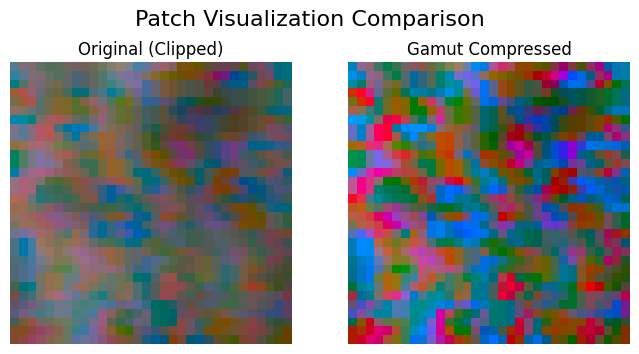

In [20]:
# Импортируем 'color' из scikit-image для преобразования цветовых пространств.
from skimage import color

if 'dataset' in locals() and dataset is not None and 'normalization_stats' in locals():
    # --- 1. Берём один случайный патч из нашего набора данных ---
    # Перемешиваем датасет, чтобы при каждом запуске получать новый случайный образец.
    shuffled_dataset = dataset.shuffle(buffer_size=1000)
    sample_patch_normalized = next(iter(shuffled_dataset))

    # --- 2. Де-нормализуем каналы Q и U обратно в их физические единицы ---
    # Получаем исходные min/max значения из нашего сохранённого файла статистики.
    min_q_orig = normalization_stats['Q']['min']
    max_q_orig = normalization_stats['Q']['max']
    min_u_orig = normalization_stats['U']['min']
    max_u_orig = normalization_stats['U']['max']

    # Де-нормализуем по формуле: X_исх = X_норм * (X_макс - X_мин) + X_мин
    patch_q_physical = sample_patch_normalized[:, :, 1] * (max_q_orig - min_q_orig) + min_q_orig
    patch_u_physical = sample_patch_normalized[:, :, 2] * (max_u_orig - min_u_orig) + min_u_orig

    # --- 3. "Обрезаем" (clip) по 99% перцентильному диапазону ВСЕЙ КАРТЫ НЕБА ---
    # Мы вычисляем эти перцентили по полномасштабным картам для согласованности.
    q_min_perc, q_max_perc = np.percentile(cmb_map_Q, [0.5, 99.5])
    u_min_perc, u_max_perc = np.percentile(cmb_map_U, [0.5, 99.5])

    patch_q_clipped = np.clip(patch_q_physical, q_min_perc, q_max_perc)
    patch_u_clipped = np.clip(patch_u_physical, u_min_perc, u_max_perc)

    # --- 4. Повторно нормализуем "обрезанные" значения для преобразования в LAB ---
    final_norm_q = (patch_q_clipped - q_min_perc) / (q_max_perc - q_min_perc)
    final_norm_u = (patch_u_clipped - u_min_perc) / (u_max_perc - u_min_perc)

    # Канал температуры (I) остаётся без изменений.
    final_norm_i = sample_patch_normalized[:, :, 0]

    # --- 5. Преобразуем в LAB, а затем в RGB ---
    channel_L = final_norm_i * 100
    channel_a = (final_norm_q * 255) - 128
    channel_b = (final_norm_u * 255) - 128

    lab_image = np.stack([channel_L, channel_a, channel_b], axis=-1)
    rgb_image_compressed = color.lab2rgb(lab_image)

    # --- 6. Визуализируем результат для сравнения ---
    print("Визуализация отдельного патча с компрессией цветового диапазона...")
    plt.figure(figsize=(8, 4))

    # Слева - оригинальная, "тусклая" версия с отсечением цветов.
    plt.subplot(1, 2, 1)
    original_lab_image = np.stack([
        sample_patch_normalized[:, :, 0] * 100,
        (sample_patch_normalized[:, :, 1] * 255) - 128,
        (sample_patch_normalized[:, :, 2] * 255) - 128
    ], axis=-1)
    original_rgb_image = color.lab2rgb(original_lab_image)
    plt.imshow(original_rgb_image)
    plt.title("Original (Clipped)")
    plt.axis('off')

    # Справа - наша новая, более контрастная версия.
    plt.subplot(1, 2, 2)
    plt.imshow(rgb_image_compressed)
    plt.title("Gamut Compressed")
    plt.axis('off')

    plt.suptitle("Patch Visualization Comparison", fontsize=16)
    plt.show()

else:
    print("Датасет или статистика для нормализации не загружены. Пожалуйста, сначала запустите ячейку настройки.")


### Шаг 4: Финальная визуализация полной карты неба

Этот шаг реализует наш финальный, самый эффективный и надёжный метод для создания полномасштабной цветной карты неба. Мы используем гибридный подход "рендер-затем-композитинг", который сочетает в себе лучшее из двух миров: скорость и стабильность специализированной библиотеки `healpy` и гибкость математических операций с изображениями в `NumPy` и `scikit-image`.

### Шаг 4.1: Рендеринг научных каналов в файлы

Этот шаг реализует первую часть нашего финального, самого эффективного "хака". Мы используем высокооптимизированную функцию `hp.mollview` для проекции каждой из трёх научных карт (I, Q, U) в отдельное, контрастное чёрно-белое изображение (`.png`).

Ключевые моменты этого процесса:
* **Повышение контраста:** Для каждого канала мы сначала применяем галактическую маску, чтобы исключить яркие помехи. Затем мы вычисляем статистический диапазон, содержащий 99% чистого сигнала (от 0.5 до 99.5 перцентиля), и "растягиваем" его на всю шкалу яркости.
* **Визуализация маски:** Маскированные области явно закрашиваются нейтральным серым цветом, чтобы наглядно показать, какие данные исключены.

Эти три файла послужат "слоями" для нашего финального композитинга на следующем шаге.

In [33]:
# Импортируем Python Imaging Library (PIL) для работы с изображениями на следующем шаге.
from PIL import Image

if 'cmb_map_I' in locals():
    print("--- Шаг 4.1: Рендеринг маскированных, высококонтрастных карт I, Q, U в файлы PNG ---")

    # Определяем имена файлов для наших финальных изображений.
    i_map_filename = os.path.join(data_path, "render_I_final.png")
    q_map_filename = os.path.join(data_path, "render_Q_final.png")
    u_map_filename = os.path.join(data_path, "render_U_final.png")

    # --- Рендеринг и сохранение карты Температуры (I) ---
    print("Рендеринг карты Температуры (I)...")
    # 1. Создаём маскированную версию карты для вычисления статистики.
    masked_I = np.ma.masked_where(galactic_mask == 0, cmb_map_I)
    # 2. Находим перцентили ТОЛЬКО по немаскированным данным.
    i_min, i_max = np.percentile(masked_I.compressed(), [0.5, 99.5])
    # 3. "Обрезаем" (clip) оставшиеся выбросы в исходной карте.
    clipped_I = np.clip(cmb_map_I, i_min, i_max)
    # 4. Создаём версию для отрисовки, где пиксели под маской заменяются на специальное значение UNSEEN.
    plot_map_I = np.copy(clipped_I)
    plot_map_I[galactic_mask == 0] = hp.UNSEEN
    # 5. Рендерим, указывая healpy закрасить UNSEEN пиксели серым цветом.
    hp.mollview(plot_map_I, cmap='gray', cbar=False, title="", notext=True, badcolor='gray')
    plt.savefig(i_map_filename, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close() # Закрываем график, чтобы освободить память.

    # --- Рендеринг и сохранение карты Поляризации (Q) ---
    print("Рендеринг карты Поляризации (Q)...")
    masked_Q = np.ma.masked_where(galactic_mask == 0, cmb_map_Q)
    q_min, q_max = np.percentile(masked_Q.compressed(), [0.5, 99.5])
    clipped_Q = np.clip(cmb_map_Q, q_min, q_max)
    plot_map_Q = np.copy(clipped_Q)
    plot_map_Q[galactic_mask == 0] = hp.UNSEEN
    hp.mollview(plot_map_Q, cmap='gray', cbar=False, title="", notext=True, badcolor='gray')
    plt.savefig(q_map_filename, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

    # --- Рендеринг и сохранение карты Поляризации (U) ---
    print("Рендеринг карты Поляризации (U)...")
    masked_U = np.ma.masked_where(galactic_mask == 0, cmb_map_U)
    u_min, u_max = np.percentile(masked_U.compressed(), [0.5, 99.5])
    clipped_U = np.clip(cmb_map_U, u_min, u_max)
    plot_map_U = np.copy(clipped_U)
    plot_map_U[galactic_mask == 0] = hp.UNSEEN
    hp.mollview(plot_map_U, cmap='gray', cbar=False, title="", notext=True, badcolor='gray')
    plt.savefig(u_map_filename, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

    print("\nВсе три маскированных, высококонтрастных канала были отрендерены и сохранены.")
else:
    print("Исходные карты не найдены. Пожалуйста, сначала запустите ячейку настройки.")

--- Шаг 4.1: Рендеринг маскированных, высококонтрастных карт I, Q, U в файлы PNG ---
Рендеринг карты Температуры (I)...
Рендеринг карты Поляризации (Q)...
Рендеринг карты Поляризации (U)...

Все три маскированных, высококонтрастных канала были отрендерены и сохранены.


### Шаг 4.2: Векторизованный композитинг в LAB

Этот финальный шаг реализует вторую часть нашего "хака". Мы загружаем три созданных чёрно-белых изображения и используем мощь NumPy для выполнения мгновенных, векторизованных операций над всеми пикселями одновременно. Мы интерпретируем яркость пикселей из наших трёх изображений как каналы L, a, b и преобразуем их в цветное RGB-изображение.

В конце мы не только отображаем результат, но и сохраняем его в отдельный файл для использования в статьях и презентациях.

--- Шаг 4.2: Выполнение векторизованного преобразования LAB -> RGB ---
Исходные чёрно-белые изображения загружены в массивы NumPy.
Создан LAB-массив. Преобразование в RGB...


/tmp/ipython-input-34-3604106265.py:30: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 43684 negative Z values that have been clipped to zero
  final_rgb_array = color.lab2rgb(lab_image_array)



Отображение и сохранение финального композитного изображения...


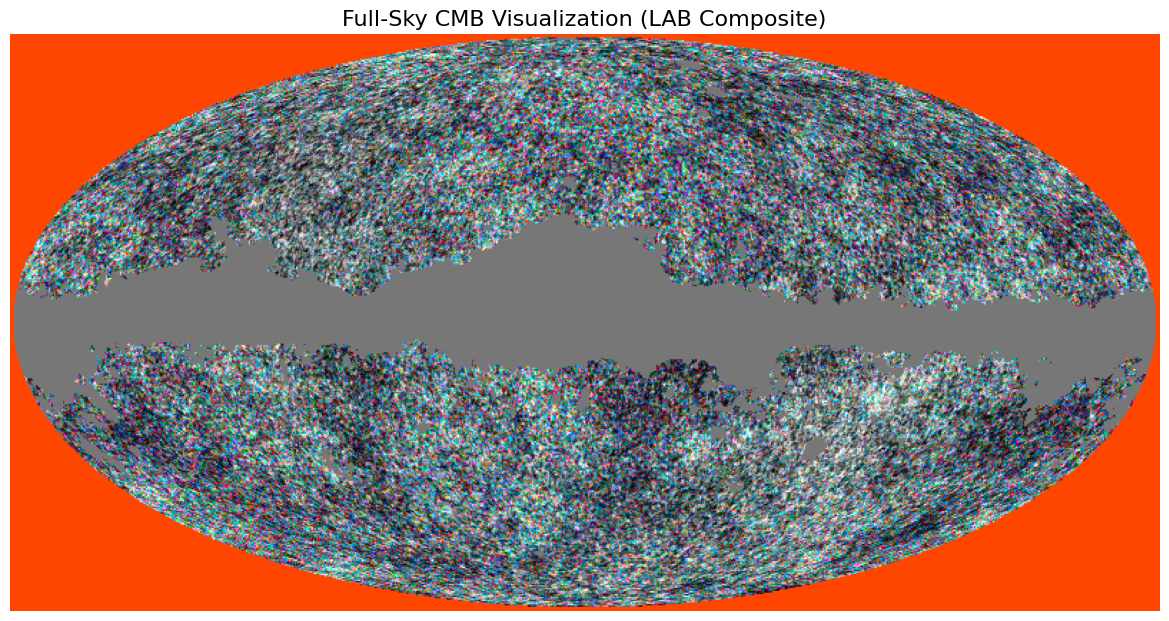

Финальное изображение сохранено в: /content/drive/My Drive/CosmicLegacy/data/final_cmb_lab_composite.png


In [34]:
# Импортируем необходимые библиотеки для этого шага.
from skimage import color
from PIL import Image

if 'i_map_filename' in locals():
    print("--- Шаг 4.2: Выполнение векторизованного преобразования LAB -> RGB ---")

    try:
        # --- 1. Загружаем изображения в массивы NumPy ---
        # Мы загружаем изображения и сразу преобразуем их в массивы NumPy с типом float.
        img_I_array = np.array(Image.open(i_map_filename).convert("L"), dtype=np.float64)
        img_Q_array = np.array(Image.open(q_map_filename).convert("L"), dtype=np.float64)
        img_U_array = np.array(Image.open(u_map_filename).convert("L"), dtype=np.float64)
        print("Исходные чёрно-белые изображения загружены в массивы NumPy.")

        # --- 2. Выполняем арифметику над всеми пикселями сразу ---
        # Это векторизованное преобразование. Оно чрезвычайно быстрое.
        # Преобразуем диапазон яркости [0, 255] в целевые диапазоны LAB.
        L_channel = (img_I_array / 255.0) * 100
        a_channel = (img_Q_array / 255.0) * 255 - 128
        b_channel = (img_U_array / 255.0) * 255 - 128

        # --- 3. Объединяем массивы в один LAB-массив ---
        # np.stack "склеивает" три 2D-массива в один 3D-массив (высота, ширина, 3 канала).
        lab_image_array = np.stack([L_channel, a_channel, b_channel], axis=-1)
        print("Создан LAB-массив. Преобразование в RGB...")

        # --- 4. Преобразуем весь массив в RGB за одну операцию ---
        # Эта функция высоко оптимизирована для работы с массивами NumPy.
        final_rgb_array = color.lab2rgb(lab_image_array)

        # --- 5. Отображаем и сохраняем финальное изображение ---
        print("\nОтображение и сохранение финального композитного изображения...")
        plt.figure(figsize=(15, 7.5))
        plt.imshow(final_rgb_array)
        plt.axis('off')
        plt.title("Full-Sky CMB Visualization (LAB Composite)", fontsize=16)

        # Сохраняем финальное изображение.
        final_image_path = os.path.join(data_path, "final_cmb_lab_composite.png")
        # bbox_inches='tight' и pad_inches=0 убирают лишние белые поля вокруг картинки.
        plt.savefig(final_image_path, dpi=300, bbox_inches='tight', pad_inches=0)

        plt.show()
        print(f"Финальное изображение сохранено в: {final_image_path}")

    except FileNotFoundError:
        print("Не удалось найти отрендеренные PNG файлы. Пожалуйста, сначала запустите предыдущую ячейку.")
else:
    print("Пожалуйста, сначала запустите ячейку рендеринга (Шаг 4.1).")

### Заключение

Этот экспериментальный ноутбук успешно выполнил свою задачу. Мы не только протестировали нашу оригинальную идею по визуализации многоканальных данных в цветовом пространстве LAB, но и в процессе сложной отладки разработали высокоэффективный и надёжный метод для создания таких изображений.

**Ключевые результаты:**
* Мы подтвердили, что сопоставление `I -> L`, `Q -> a`, `U -> b` даёт физически осмысленные и визуально интересные результаты.
* Мы разработали "хак" "рендер-затем-композитинг", который обходит проблемы с памятью и производительностью, позволяя создавать высококачественные полномасштабные карты.
* Мы отточили технику повышения контрастности и маскирования для получения чистых и наглядных иллюстраций.

Разработанные здесь алгоритмы и полученные изображения станут важной частью наших будущих статей и презентаций по проекту «Квантовое Наследие».